In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import multiprocessing as mp
import os

from torchvision.datasets import MNIST

from profilehooks import profile
import matplotlib.pylab as plt

#### Get number of threads and choose range of number of clusters

In [16]:
with open('/proc/cpuinfo') as f:
    lines = f.readlines()
    N_PROC = len([l for l in lines if l.lower().find('processor')>-1])
print(f'Can use {N_PROC} threads')

N_CLUSTER_LOW = 5
N_CLUSTER_HIGH = 25
N_INIT = int(100 / (12 / N_PROC))

Can use 12 threads


### Workload

This workload runs K-means clustering on the MNIST dataset for a range of n_cluster values. The idea is to see how well a simple clustering on raw pixel values segments the data since we have labels. There are no embeddings of the data using a neural network and no feature transformations apart from scaling each feature to mean = 0 and standard deviation = 1.

Note that K-means is run on the full dataset for a range of n_cluster values. In addition, for each n_cluster value, by default, scikit-learn's implementation runs the algorithm n_init = 10 times with different random initializations of the cluster locations. Each of these runs is distributed across all available threads by scikit-learn. In addition, we run the range of cluster_values in parallel using multiple threads.

In [4]:
data = MNIST('./', download=True)

In [5]:
#flatten each image
data = data.train_data.numpy().reshape(data.train_data.shape[0], -1).astype(np.float32)
print(data.shape)

(60000, 784)


In [6]:
class Cluster:
    def __init__(self, data,                
                 n_clusters_low=2, 
                 n_clusters_high=50, 
                 n_clusters_stepsize=5, 
                 n_processes=None):

        self.data = data.copy()

        self.data_normalized = None  # zscore -> pca -> zscore

        #clustering scan
        self.n_clusters_low = n_clusters_low
        self.n_clusters_high = n_clusters_high
        self.n_clusters_stepsize = n_clusters_stepsize
        self.n_processes = n_processes

        self.models_dict = None
        self.inertia_dict = None

        #clustering optimal
        self.n_clusters_optimal = None
        self.kmeans_optimal = None

    @profile(immediate=True)
    def train(self):
        self.preprocess_normalize()

        if self.n_processes is None:
            self.find_nclusters()
        else:
            self.find_nclusters_parallel()

        #self.find_elbow()  # hard-coded currently


    def preprocess_normalize(self):        
        self.scaler = StandardScaler()
        self.data_normalized = self.scaler.fit_transform(self.data)

    def find_nclusters(self):
        print('Calling find_nclusters...')
        if self.data_normalized is None:
            raise AttributeError("Please call preprocess_normalize to prepare data for clustering.")

        self.inertia_dict, self.models_dict = {}, {}
        for ncl in range(self.n_clusters_low, self.n_clusters_high, self.n_clusters_stepsize):
            kmeans = KMeans(n_clusters=ncl, n_init=N_INIT)
            kmeans.fit(self.data_normalized)

            self.inertia_dict[ncl] = kmeans.inertia_
            self.models_dict[ncl] = kmeans

    def find_nclusters_parallel(self):
        print('Calling find_nclusters_parallel...')
        manager = mp.Manager()
        models_shared_dict = manager.dict()
        inertia_shared_dict = manager.dict()

        proc_list = []
        counter = 0
        def run(data, ncl):
            kmeans = KMeans(n_clusters=ncl, n_init=N_INIT)
            kmeans.fit(data)

            inertia_shared_dict[ncl] = kmeans.inertia_
            models_shared_dict[ncl] = kmeans

        for ncl in range(self.n_clusters_low, self.n_clusters_high, self.n_clusters_stepsize):
            proc = mp.Process(target=run, args=(self.data_normalized, ncl,))
            proc.start()
            proc_list.append(proc)
            counter += 1

            if counter % self.n_processes == 0:
                [p.join() for p in  proc_list]
                proc_list = []

        [p.join() for p in proc_list]

        self.inertia_dict = dict(inertia_shared_dict)
        self.models_dict = dict(models_shared_dict)
    
    def find_elbow(self):
        if self.inertia_dict is None:
            raise AttributeError("Please run find_nclusters to populated inertia_dict.")
        
        keys = np.sort(list(self.inertia_dict.keys()))
        values = np.array([self.inertia_dict[k] for k in keys])

        N = len(keys)

        thresholds = np.arange(2, N-1) #indices to slice at

        threshold_cuts, score_means = [], []

        for t in thresholds:
            model1, model2 = LinearRegression(), LinearRegression()

            domain1 = np.arange(t)
            domain2 = np.arange(t, N)
            
            model1.fit(keys[domain1].reshape(-1,1), values[domain1])
            model2.fit(keys[domain2].reshape(-1,1), values[domain2])

            score1 = model1.score(keys[domain1].reshape(-1,1), values[domain1])
            score2 = model2.score(keys[domain2].reshape(-1,1), values[domain2])

            score = (score1+score2)/2.0
            
            threshold_cuts.append(keys[t])
            score_means.append(score)

        self.n_clusters_optimal = threshold_cuts[np.argmax(score_means)]

        return threshold_cuts, score_means


### Some run times

n_clusters_low = 5, n_clusters_high = 6,  n_processes = None : ~65 seconds

n_clusters_low = 5, n_clusters_high = 6,  n_processes = 10   : ~70 seconds

n_clusters_low = 5, n_clusters_high = 15, n_processes = None : ~963 seconds

n_clusters_low = 5, n_clusters_high = 15, n_processes = 10   : ~207 seconds

In [7]:
cl = Cluster(data, n_clusters_low=N_CLUSTER_LOW, n_clusters_high=N_CLUSTER_HIGH, n_clusters_stepsize=1, n_processes=N_PROC)
cl.train()

Calling find_nclusters_parallel...

*** PROFILER RESULTS ***
train (<ipython-input-6-9982fd8e51fa>:25)
function called 1 times

         7338 function calls (7273 primitive calls) in 4832.514 seconds

   Ordered by: cumulative time, internal time, call count
   List reduced from 366 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000 4832.514 4832.514 <ipython-input-6-9982fd8e51fa>:25(train)
        1    0.002    0.002 4831.479 4831.479 <ipython-input-6-9982fd8e51fa>:54(find_nclusters_parallel)
       21    0.000    0.000 4830.665  230.032 process.py:118(join)
       21    0.000    0.000 4830.664  230.032 popen_fork.py:43(wait)
      137    0.000    0.000 4830.657   35.260 popen_fork.py:24(poll)
      136 4830.656   35.520 4830.656   35.520 {built-in method posix.waitpid}
        1    0.000    0.000 2537.727 2537.727 <ipython-input-6-9982fd8e51fa>:76(<listcomp>)
        1    0.000    0.000 2292.926 2292.926 

Each column in the table below is a single cluster. The rows show the number of images in a particular cluster that belong to each digit (rows).

E.g.:

Cluster 9 contains both "7" and "9" which are similar in shape

Cluster 2 is dominated by "0"s

Cluster 1 contains "4", "7" and "9" which are also similar in shape

In [9]:
pred = cl.models_dict[10].predict(cl.data_normalized)
labels = MNIST('./', download=True).train_labels.numpy()

comp = pd.DataFrame({'clusterid': pred, 'label': labels})
comp['count'] = 1
pd.pivot_table(comp, index='label', columns='clusterid', values='count', aggfunc='sum')

clusterid,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,79.0,10.0,798.0,21.0,4.0,3407.0,31.0,386.0,527.0,660.0
1,12.0,1.0,20.0,6.0,3.0,NaN,6527.0,11.0,16.0,146.0
2,2238.0,44.0,618.0,171.0,25.0,35.0,698.0,1470.0,534.0,125.0
3,178.0,81.0,3729.0,169.0,69.0,9.0,620.0,991.0,84.0,201.0
4,45.0,392.0,4.0,3461.0,487.0,38.0,456.0,24.0,111.0,824.0
5,119.0,71.0,1740.0,283.0,60.0,23.0,460.0,135.0,110.0,2420.0
6,690.0,5.0,59.0,29.0,1.0,196.0,395.0,11.0,4421.0,111.0
7,6.0,761.0,10.0,1443.0,3444.0,19.0,456.0,12.0,2.0,112.0
8,92.0,93.0,1759.0,340.0,119.0,37.0,1153.0,70.0,32.0,2156.0


One method to find the optimal number of clusters is to look at the so-called elbow plot of the inertia (sum of distances of each point from its cluster's center) vs the number of clusters. As the number of clusters approaches the number of data points, inertia approaches 0 (since each point is its own clusters). Often, there is a num_cluster values at which the plot shows a dramatic change in slope (slope becomes less negative i.e. increases). This doesn't happen here which is expected since even some variation in an image (pixel-wise translation) can result in a big increase in Euclidean distance but none in the label.

One way to automatically identify the elbow plot is to split the number of clusters axis at different points and fit both the left and right side of the point with linear models. If there's a sharp elbow, both fits should be very good leading to a local maximum of the average R^2 metric. This is implemented in Cluster.find_elbow.

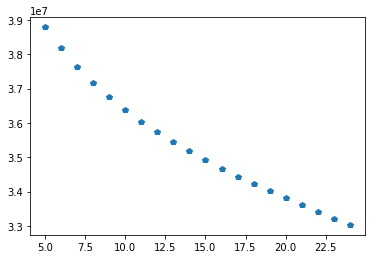

In [10]:
plt.plot(cl.inertia_dict.keys(), cl.inertia_dict.values(), 'p')

In [11]:
threshold_cuts, score_means = cl.find_elbow()

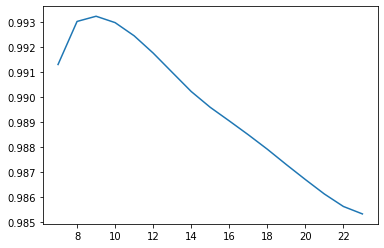

In [14]:
plt.plot(threshold_cuts, score_means)

In the plot above, the best average $R^2$ score at n_clusters = 10 indicating we should pick 10 as the value for num_clusters.